# Fast sigmoid sampling

In this notebook, we describe a simple trick for efficiently sampling a Bernoulli random variable $Y$ from a sigmoid-defined distribution, $p(Y = 1) = (1 + \exp(-x))^{-1}$, where $x \in \mathbb{R}$ is the only parameter of the distribution ($x$ is often defined as the dot product of features and weights).

The "slow" method for sampling from a sigmoid,

$$
u \sim \textrm{Uniform}(0,1)
$$
$$
Y = \textrm{sigmoid}(x) > u
$$

This method is slow because it calls the sigmoid function for every value of $x$. It is slow because $\exp$ is 2-3x slower than basic arithmetic operations.

In this post, I'll describe a simple trick, which is well-suited to vectorized computations (e.g., numpy, matlab). The way it works is by *precomputing* the expensive stuff (i.e., calls to expensive functions like $\exp$).

$$
\textrm{sigmoid}(x) > u \Leftrightarrow \textrm{logit}(\textrm{sigmoid}(x)) > \textrm{logit}(u) \Leftrightarrow x > \textrm{logit}(u).
$$

Some details worth mentioning: (a) [logit](https://en.wikipedia.org/wiki/Logit) is the inverse of sigmoid&mdash;sometimes it's called [expit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html) to highlight this connection&mdash;and (b) logit is strictly monotonic increasing you can apply it both sides of an inequality and preserve the ordering (there's a plot in the appendix).

The "fast" method derives it's advantage by leveraging the fact that expensive computation can be done independently of the data (i.e., specific values of $x$). The fast method is also interesting as just cute math. In the bonus section of this post, we'll make a connection to the [Gumbel-max trick](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/).

**How fast is it in practice?** Below, we run a quick experiment to test that the method is correct and how fast it is.

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
from numpy.random import uniform
from numpy import exp
from scipy.special import expit as sigmoid, logit
from arsenal.timer import timers    # https://github.com/timvieira/arsenal

fast is 26.8226x faster than slow1 (avg: slow1: 0.000353234 fast: 1.31693e-05)
slow2 is 1.0093x faster than slow1 (avg: slow1: 0.000353234 slow2: 0.000349975)
slow1 is 1.0920x faster than slow3 (avg: slow3: 0.000385725 slow1: 0.000353234)


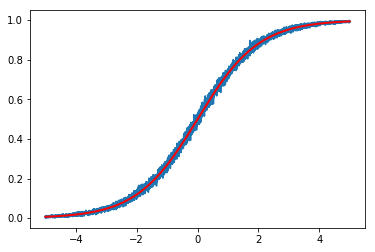

In [2]:
T = timers()

# These are the sigmoid parameters we're going to sample from.
n = 10000
X = np.linspace(-5,5,n)

# number of runs to average over.
R = 1000

# Used for plotting average p(Y=1)
F = np.zeros_like(X)

# Temporary array for saving on memory allocation, cf. method slow-2.
tmp = np.empty(n)                     

for _ in range(R):

    # Let's use the same random variables for all methods. This allows 
    # for a lower variance comparsion and equivalence testing.
    u = uniform(0,1,size=n)
    z = logit(u)       # used in fast method: precompute expensive stuff.

    # Requires computing sigmoid for each x.
    with T['slow1']:
        s1 = sigmoid(X) > u           
        
    # Avoid memory allocation in slow-1 by using the out option to sigmoid
    # function. It's a little bit faster than slow-1.
    with T['slow2']:
        sigmoid(X, out=tmp)           
        s2 = tmp > u

    # Rolling our sigmoid is a bit slower than using the library function.
    # Not to mention this implementation isn't as numerically stable.
    with T['slow3']:
        s3 = 1/(1+exp(-X)) > u
        
    # The fast method.
    with T['fast']:
        f = X > z
    
    F += f / R    
    assert (s1 == f).all()
    assert (s2 == f).all()
    assert (s3 == f).all()

pl.plot(X, F)
pl.plot(X, sigmoid(X), c='r', lw=2)
T.compare()

It looks like our trick is about $28$x faster than the fastest competing slow method!

We also see that the assert statements passed, which means that the methods tested produce precisely the same samples. 

The final plot demonstrates that we get the right expected value (red curve) as we sweep the distributions parameter (x-axis).

## Bonus

We could alternatively use the [Gumbel-max trick](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to derive a similar algorithm. If we ground out the trick for a sigmoid instead of a general mutlinomal distributions, we end up with

$$
Z_0 \sim \textrm{Gumbel}(0,1)
$$
$$
Z_1 \sim \textrm{Gumbel}(0,1)
$$
$$
Y = x > Z_0 - Z_1
$$

Much like our new trick, this one benefits from the fact that all expensive stuff is done independent of the data (i.e., the value of $x$). However, it seems silly that we "need" to generate *two* Gumbel RVs to get one sample from the sigmoid. With a little bit of Googling, we discover that the difference of $\textrm{Gumbel}(0,1)$ RVs is a [logistic](https://en.wikipedia.org/wiki/Logistic_distribution) RV (specifically $\textrm{Logistic}(0,1)$).

It turns out that $\textrm{logit}(\textrm{Uniform}(0,1))$ is a $\textrm{Logistic}(0,1)$ RV.

Voila! Our fast sampling trick and the Gumbel max trick are connected!


## Related tricks

Another trick is Justin Domke's [trick](https://justindomke.wordpress.com/2014/01/08/reducing-sigmoid-computations-by-at-least-88-0797077977882/) to reduce calls to $\exp$ by $\approx 88\%$. The *disadvantage* of this approach is that it's harder to implement with vectorization. The *advantage* is that we don't need to precompute any expensive things.

## Appendix

### Logit plot

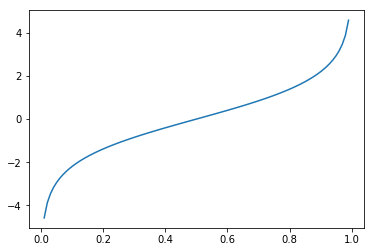

In [3]:
xs = np.linspace(0,1,100)
ys = logit(xs)
pl.plot(xs, ys);

### Logistic random variable

Check that our sampling method is equivalent to sampling from a logistic distribution.

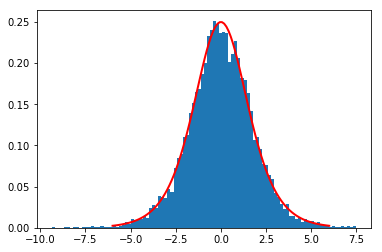

In [4]:
from scipy.stats import logistic
u = uniform(0,1,size=10000)
z = logit(u)
pl.hist(z, bins=100, normed=1)
xs = np.linspace(-6,6,100)
ys = logistic.pdf(xs)
pl.plot(xs, ys, c='r', lw=2);